In [144]:
%load_ext autoreload
%autoreload 2

In [145]:
from spikeship import spikeship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch, os
from tqdm import tqdm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, spectral_embedding, TSNE

In [146]:
def tensor2spikeship(rp_tensor):
    N_epochs, N_neurons, N_timesteps = rp_tensor.shape
    #epochs, neurons, times = np.where(rp_tensor>0)
    spike_times = np.array([])
    ii_spike_times = np.zeros([N_epochs, N_neurons, 2])
    nb_previous_timestamps = 0
    last_previous_timestamp = 0
    for e in tqdm(range(N_epochs)):
        neurons, times = np.where(rp_tensor[e,:,:]>0)
        for n in np.unique(neurons):
            indices = np.where(neurons==n)[0]
            ii_spike_times[e,n,:] = [indices[0], indices[-1]+1] + np.ones([2])*nb_previous_timestamps
            spike_times = np.hstack([spike_times,times[indices]]) if spike_times.shape[0]>0 else times[indices]
        nb_previous_timestamps += len(times)
        #last_previous_timestamp += times[-1]
    return spike_times, ii_spike_times

def plot_raster(raster, trial_nb = 0, colored=False, title = 'raster plot'):

    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    xticks, yticks = 6, 16
    spikelength=.9
    colors = ['grey', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
    figsize = (12, 1.61803)
    linewidths=5.0
    
    if colored:
        N_kernels, N_trials, N_neurons, N_timesteps = raster.shape
    else:
        N_trials, N_neurons, N_timesteps = raster.shape

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
    if colored:
        for i in range(0, N_neurons):
            for sm in range(N_kernels):
                ax.eventplot(np.where(raster[sm, trial_nb, i, :] > 0)[0],
                    colors=colors[sm], lineoffsets=1.*i+spikelength/2,
                    linelengths=spikelength, linewidths=linewidths)
    else:
        for i in range(0, N_neurons):
            ax.eventplot(np.where(raster[trial_nb, i, :] > 0)[0],
                colors=colors[0], lineoffsets=1.*i+spikelength/2,
                linelengths=spikelength, linewidths=linewidths)

    ax.set_ylabel('address')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, N_timesteps)
    ax.set_ylim(0, N_neurons)

    ax.set_yticks(np.arange(0, N_neurons, 1)+.5)
    ax.set_yticklabels('')#np.linspace(1, N_neurons, 9, endpoint=True).astype(int))
    for side in ['top', 'right']: ax.spines[side].set_visible(False)

    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(N_timesteps/4))
    ax.set_xticks(np.linspace(1, N_timesteps, xticks, endpoint=True))
    ax.set_xticklabels(np.linspace(1, N_timesteps, xticks, endpoint=True).astype(int))
    ax.set_title(title)

    ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
    #ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)
    return fig, ax

def plot_SM(SMs, N_show = 5, cmap='plasma', colors=None, aspect=None, figsize = (12, 1.61803)):
    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    N_SMs, N_pre, N_delays = SMs.shape

    fig, axs = plt.subplots(1, N_show, figsize=figsize, subplotpars=subplotpars)
    for i_SM in range(N_show):
        ax = axs[i_SM]
        ax.set_axisbelow(True)
        ax.pcolormesh(SMs[i_SM, :, :].flip(1), cmap=cmap, vmin=SMs.min(), vmax=SMs.max())
        #ax.imshow(self.SMs[:, i_SM, :], cmap=cmap, vmin=0, vmax=1, interpolation='none')
        ax.set_xlim(0, N_delays)
        ax.set_xlabel('Delay')
        t = ax.text(.805*N_delays, .95*N_pre, f'#{i_SM+1}', color='k' if colors is None else colors[i_SM])
        t.set_bbox(dict(facecolor='white', edgecolor='white'))
        if not aspect is None: ax.set_aspect(aspect)

        ax.set_ylim(0, N_pre)
        ax.set_yticks(np.arange(0, N_pre, 1)+.5)
        if i_SM>0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(np.arange(0, N_pre, 1)+1)

        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        ax.set_xticks([1, N_delays//3, (N_delays*2)//3])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(N_delays//4))

    axs[0].set_ylabel('@ Neuron')
    return fig, axs

def gaussian_kernel(n_steps, mu, std):
    x = torch.arange(n_steps)
    return torch.exp(-(x-mu)**2/(2*std**2))/(std*torch.sqrt(torch.Tensor([2*torch.pi])))

In [147]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
        self.add_coef = add_coef

        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            self.kernels[self.kernels>1] = 1

        if add_coef is not None:
            self.draw_mixture(add_coef)
            

    def draw_mixture(self, add_coef):
        add_coef = torch.hstack([add_coef,torch.zeros(1)])
        if self.kernels.shape[0]==self.opt.N_kernels:
            self.kernels = torch.cat((self.kernels, torch.zeros(1, self.kernels.shape[1], self.kernels.shape[2])), 0)
        
        self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T
        self.add_coef = add_coef
    
    def draw_input_one_sm(self, N_trials = 1):
        #spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous
        labels = torch.randint(self.kernels.shape[0], [N_trials])
        max_proba = torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])
        input_rp = torch.zeros([N_trials, self.opt.N_pre, self.opt.N_timesteps])
        
        if self.add_coef is not None:
            output_labels = self.add_coef.repeat(N_trials,1)
        else:
            output_labels = labels
        for k in range(self.kernels.shape[0]):
            indices = labels == k
            input_rp[indices,:,:] = torch.bernoulli(torch.min(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1), max_proba[indices,:,:]))
            if self.add_coef is not None:
                if k<(self.kernels.shape[0]-1):
                    output_labels[indices,:] = k
                else:
                    output_labels[indices,-1] = k
        return input_rp, output_labels

In [148]:
class world_params:
    N_pre = 10 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 5 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

## Model with 2 motifs and a combination of the 2

In [149]:
N_trials = 1000
add_coef = torch.Tensor([.2,.7,.1])
add_coef=None

In [150]:
opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials)

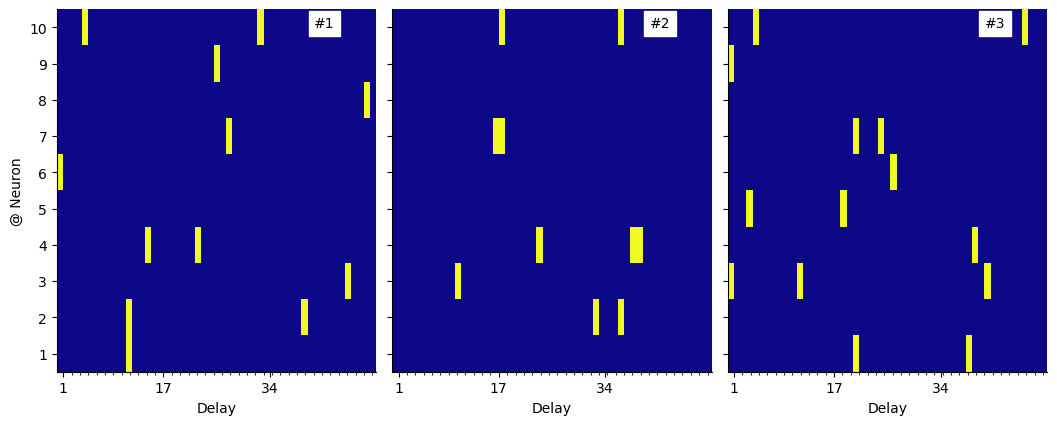

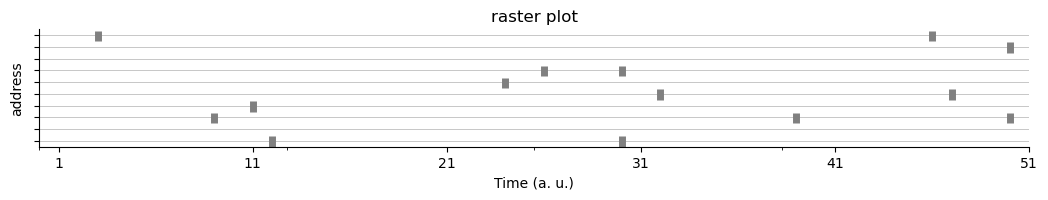

In [151]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

### Format the ouput for SpikeShip

In [152]:
def make_dataset(world, N_trials=20, N_coef_changes=5, values=None, normalize_coef=False, data_folder = '../Data/'):
    
    path = data_folder+f'synthetic_data_first_gm_{world.opt.N_kernels}_{world.opt.N_delays}_{world.opt.N_pre}_{world.opt.p_input}_{world.opt.avg_precision}_{N_trials}_{N_coef_changes}_{values}_{normalize_coef}'
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
        
    if os.path.exists(path):
        data, labels = np.load(path+'_data.npy', path+'_labels.npy')
        return data, labels
        
    #check if saved
    stacked_input = torch.Tensor([])
    stacked_labels = torch.Tensor([])

    if world.add_coef is not None:
        coef_number = world.add_coef.shape[0]-1
    else:
        coef_number = world.kernels.shape[0]
        
    if values is not None:
        ind_val = torch.randint(values.shape[0], [N_coef_changes, coef_number])
        sampled_val = torch.index_select(values, 0, ind_val.flatten()).reshape([N_coef_changes, coef_number])
    else:
        sampled_val = torch.rand([N_coef_changes, coef_number])
    
    if normalize_coef:
        sampled_val = torch.nn.functional.normalize(sampled_val, p=1, dim=1)

    stacked_input, stacked_labels = world.draw_input_one_sm(N_trials = N_trials)
    print(stacked_labels.shape)
    if world.add_coef is None and N_coef_changes>=1:
        print(coef_number)
        stacked_labels = stacked_labels.unsqueeze(1).repeat(1,coef_number+1)
        print(stacked_labels.shape)

    for n in range(N_coef_changes):
        world.draw_mixture(sampled_val[n,:])
        input_rp, output_labels = world.draw_input_one_sm(N_trials = N_trials)
        stacked_input = torch.vstack([stacked_input,input_rp])
        stacked_labels = torch.vstack([stacked_labels,output_labels])
        
    np.save(path+'_data', stacked_input)
    np.save(path+'_labels', stacked_labels)
    return stacked_input, stacked_labels

In [153]:
data, labels = make_dataset(world, N_trials=2000, N_coef_changes=1)

torch.Size([2000])
3
torch.Size([2000, 4])


### Remove trials with neurons and no spike (gives np.nan in S_dist) - TODO: find a better generative model

In [ ]:
if (stacked_input.sum(dim=(1,2))<1).sum()>0:
    print(f'{(stacked_input.sum(dim=(1,2))<1).sum()} trials with no spike for at least one neuron')
    spike_ind = (stacked_input.sum(dim=(1,2))>=1)
    input_rp, labels = stacked_input[spike_ind,:,:], stacked_labels[spike_ind]
else:
    input_rp, labels = stacked_input, stacked_labels

In [ ]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)
ii_spike_times = ii_spike_times.astype('int32')
labels = labels.numpy()

In [ ]:
print(input_rp.shape, ii_spike_times.shape)

In [ ]:
%%time
S_dist = spikeship.distances(spike_times, ii_spike_times)

In [ ]:
if np.isnan(S_dist).sum():
    print(f'{np.isnan(S_dist).sum()/(S_dist.shape[0]**2)*100}% of nan values')

In [ ]:
print(np.unique(S_dist))

In [ ]:
print(labels.shape)

In [ ]:
si = np.argsort(labels[:,-1])
print(si.shape)

### Dissimilarity matrix

In [ ]:
fig, axs = plt.subplots(figsize=(5,5), facecolor='w')
axs.set_xlabel("Epoch"); axs.set_ylabel("Epoch");
#axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");
im = axs.imshow(S_dist[:,si][si], cmap='PuBu')
axs.set_title("Sorted Dissimilarity Matrix")
cbar = plt.colorbar(im, ax=axs)
cbar.set_label("SpikeShip", fontsize=10)

## Linear dimensionnality reduction methods
### Principal component analysis

In [ ]:
number_of_components = len(world.add_coef)-1
colors = ['r', 'g', 'b']

In [ ]:
pca = PCA(n_components=number_of_components)
pca.fit(S_dist)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
pca.components_.shape

In [ ]:
labels[indices,0].shape, pca.fit_transform(S_dist)[indices,0].shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=colors[int(l)])#, label=f'{np.round(l*100)}%')
    else:
        ax.scatter(pca.fit_transform(S_dist)[indices,0], pca.fit_transform(S_dist)[indices,1], facecolors=labels[indices,:3])
#ax.legend(loc='upper right')
ax.set_title('PCA');

### Singular value decomposition 

In [ ]:
svd = TruncatedSVD(n_components=number_of_components, n_iter=51, random_state=42)
svd.fit(S_dist)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(svd.fit_transform(S_dist)[indices,1], svd.fit_transform(S_dist)[indices,2], facecolors=colors[int(l)])
    else:
        ax.scatter(svd.fit_transform(S_dist)[indices,1], svd.fit_transform(S_dist)[indices,2], facecolors=labels[indices,:3])
ax.set_title('SVD');

## Non-linear dimensionnality reduction methods
### Multidimensionnal scaling

In [ ]:
mds_embedding = MDS(n_components=number_of_components, dissimilarity='precomputed').fit_transform(S_dist)# metric=True, normalized_stress='auto')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(mds_embedding[indices,2], mds_embedding[indices,1], facecolors=colors[int(l)])
    else:
        ax.scatter(mds_embedding[indices,2], mds_embedding[indices,1], facecolors=labels[indices,:3])
ax.set_title('MDS');

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(mds_embedding[indices,0], mds_embedding[indices,1], mds_embedding[indices,2], facecolors=colors[int(l)])
    else:
        ax.scatter(mds_embedding[indices,0], mds_embedding[indices,1], mds_embedding[indices,2], facecolors=labels[indices,:3])
ax.set_title('MDS');
ax.view_init(60, 60)

### Laplacian eigenmaps

In [ ]:
s_embedding = spectral_embedding(S_dist, n_components=number_of_components, metric='precomputed')#.fit_transform(S_dist)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(s_embedding[indices,1], s_embedding[indices,0], facecolors=colors[int(l)])
    else:
        ax.scatter(s_embedding[indices,1], s_embedding[indices,0], facecolors=labels[indices,:3])
ax.set_title('Laplacian Eigenmaps');

### 2D t-SNE emb

In [ ]:
def get_2d_tsne_embedding(diss, perplexity=70., n_components=2):
    return TSNE(metric='precomputed', n_components=n_components, random_state=0, perplexity=perplexity, init='random').fit_transform(diss)

In [ ]:
S_emb = get_2d_tsne_embedding(S_dist, perplexity = 30, n_components=number_of_components-1)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        axs.scatter(S_emb[indices,1], S_emb[indices,0], facecolors=colors[int(l)])
    else:
        axs.scatter(S_emb[indices,1], S_emb[indices,0], facecolors=labels[indices,:3])
#unique_labels = np.unique(labels)
#for i in range(len(unique_labels)):
#    label_id = unique_labels[i]
#    temp_mask = labels == label_id
#    axs.scatter(S_emb[temp_mask,0], S_emb[temp_mask,1], s = 5, cmap='Set1')
#axs.set_xlabel("1st Comp.")
#axs.set_ylabel("2nd Comp.")

axs.set_title('2D t-SNE embedding') ;

From this notebook, it seems that linear dimensionnal reduction techniques are good candidate for the present task. Maybe due to the generative model that makes a linear mixture of the 2 first patterns. It can be interesting to test other generative models for the raster plots. To add spontaneous activity and also to add more patterns for the mixture of patterns. 

### Trying to retrieve the kernels
#### Doing PCA on the trials not on S_dist

In [ ]:
input_flatten = input_rp.flatten(start_dim=1)
pca = PCA(n_components=number_of_components)
print(input_flatten.shape)
pca.fit(input_flatten)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

In [ ]:
estimated_kernels = pca.components_
print(estimated_kernels.shape)
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components+1, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

In [ ]:
plt.imshow(torch.corrcoef(torch.vstack([torch.tensor(estimated_sms).flatten(start_dim=1), world.kernels.flatten(start_dim=1)])))

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels[:,-1]):
    indices = labels[:,-1]==l
    if l<np.unique(labels[:,-1])[-1]:
        ax.scatter(pca.fit_transform(input_flatten)[indices,0], pca.fit_transform(input_flatten)[indices,1], facecolors=colors[int(l)])#, label=f'{np.round(l*100)}%')
    else:
        ax.scatter(pca.fit_transform(input_flatten)[indices,0], pca.fit_transform(input_flatten)[indices,1], facecolors=labels[indices,:3])
#ax.legend(loc='upper right')
ax.set_title('PCA');

#### Apply kernel PCA

In [ ]:
kpca = KernelPCA(n_components=number_of_components, kernel=)
print(input_flatten.shape)
pca.fit(input_flatten)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_.shape)

**`Missing:`**
+ label of each epoch.

**`Change`**:
+ Span pattern across window length or
+ Reduce SNR.

**``TODO:``**

Make different combinations of two sources in discrete steps (i.e. $\lambda=\{0,0.2,0.4,...,1\}$, then $P_3 \equiv \lambda_i P_1 + (1-\lambda_i) P_2$).

### Clustering performance

Requirements:
+ Patterns with discrete steps of mixture/combination